#### library import

In [1]:
import os
import re
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

#### vocabulary class
- idx to word: 숫자(int)를 word(string)으로 변환 
- word to idx: 반대

In [2]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

#### Main

In [3]:
if __name__=='__main__':

    img_path = './drive/My Drive/PerspectiveImages/'
    valid_data = pd.read_csv('./valid_data.csv')    # 미리 제외시켜둔 데이터의 이름 저장

#### Label to vocabulary


In [4]:
captions = [name[:-4] for name in valid_data['name']] # eliminate the .jpg
counter = Counter()
for cap in captions:
    for token in cap:
        counter.update(token)
        
words = [word for word, cnt in counter.items()]
vocab = Vocabulary()

for i, word in enumerate(words):
    vocab.add_word(word)

In [5]:
imgs = []
for file_name in tqdm(valid_data['name']):
    img = np.asarray(Image.open(img_path + file_name))
    imgs.append(img)

imgs = np.asarray(imgs)

100%|██████████| 809/809 [00:01<00:00, 691.32it/s]


#### Transform
- normalize 수행 X -> 왜 인지는 모르겠으나 성능 저하

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize([140.72191205357143, 142.173804375, 141.2539975], [66.03655501729828, 65.7432860955485, 65.37706592308601]),
])

In [7]:
class CustomDataset(Dataset):
    def __init__(self, imgs, vocab, captions, transform):
        self.imgs = imgs
        self.captions = captions
        self.vocab = vocab
        self.transform = transform
        
    def __getitem__(self, index):
        imgs = self.imgs
        vocab = self.vocab
        captions = self.captions
        
        image = imgs[index]
        if self.transform is not None:
            image = self.transform(image)
        
        tokens = [token for token in captions[index]]
        caption = []
        caption.extend([vocab(token) for token in tokens])
        target = torch.LongTensor(caption)
        
        return image, target
    
    def __len__(self):
        return len(self.imgs)

In [8]:
batch_size = 16
shuffle = True

c = CustomDataset(imgs, vocab, captions, transform)
data_loder = DataLoader(dataset=c,
                       batch_size=batch_size,
                       shuffle=shuffle,
                       )

train_size = int(0.8 * c.__len__())
test_size = c.__len__() - train_size

In [9]:
#torch.manual_seed(10)
train_dataset, test_dataset = data.random_split(c, [train_size, test_size])
train_loder = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
test_loder = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

#### Network
- Depthwise seperable convolution 사용
- MobileNet 구조
- 차이: 마지막 단에서 Adaptive Average pooling 사용

In [10]:
class Depthwise_seperable_conv(nn.Module):
    def __init__(self, in_channel, kernel_per_layer, out_channel, stride=1):
        super(Depthwise_seperable_conv, self).__init__()
        
        self.depthwise = nn.Sequential(nn.Conv2d(in_channel, in_channel*kernel_per_layer, kernel_size=3, stride=stride, groups=in_channel),
                                      nn.BatchNorm2d(in_channel*kernel_per_layer),
                                      nn.ReLU()
                                      )
                                       
        self.pointwise = nn.Sequential(nn.Conv2d(in_channel*kernel_per_layer, out_channel, kernel_size=1),
                                      nn.BatchNorm2d(out_channel),
                                      nn.ReLU()
                                      )
        
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x
    
class Net(nn.Module):
    def __init__(self, input_dim, output_dim, final_size):
        super(Net, self).__init__()
        
        # regular convolution
        self.reg_conv_1 = nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=(1,2))
        self.sep32_1 = Depthwise_seperable_conv(output_dim, 1, output_dim)
        self.sep32_2 = Depthwise_seperable_conv(output_dim, 2, output_dim*2)
        
        self.sep64_1 = Depthwise_seperable_conv(output_dim*2, 1, output_dim*2, stride=(1,2))
        self.sep64_2 = Depthwise_seperable_conv(output_dim*2, 2, output_dim*4)
        
        self.sep128_1 = Depthwise_seperable_conv(output_dim*4, 1, output_dim*4, stride=(1,2))
        self.sep128_2 = Depthwise_seperable_conv(output_dim*4, 1, output_dim*4)
        self.sep128_3 = Depthwise_seperable_conv(output_dim*4, 2, output_dim*8)
        
        self.sep256_1 = Depthwise_seperable_conv(output_dim*8, 1, output_dim*8, stride=(1,2))
        self.sep256_2 = Depthwise_seperable_conv(output_dim*8, 1, output_dim*8)
        self.sep256_3 = Depthwise_seperable_conv(output_dim*8, 2, output_dim*16)

        self.sep512_1 = Depthwise_seperable_conv(output_dim*16, 1, output_dim*32, stride=(1,2))

        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        # 약간의 ovefitting도 잡아보자!
        self.fc = nn.Sequential(nn.Linear(1024, 1000),
                                nn.Dropout(0.5),
                                nn.Linear(1000, final_size)
                               )
        
    def forward(self, x):
        feature = self.reg_conv_1(x)
        feature = self.sep32_1(feature)
        feature = self.sep32_2(feature)
        
        feature = self.sep64_1(feature)
        feature = self.sep64_2(feature)
        
        feature = self.sep128_1(feature)
        feature = self.sep128_2(feature)
        feature = self.sep128_3(feature)
        
        feature = self.sep256_1(feature)
        feature = self.sep256_2(feature)
        feature = self.sep256_3(feature)

        feature = self.sep512_1(feature)
        feature = self.avg_pool(feature)
        feature = self.fc(feature.reshape(feature.shape[0], -1))
        
        return feature

In [11]:
def save_checkpoint(state, filename='MobileNet.path.tar'):
    print(">>> saving checkpoing")
    torch.save(state, filename)
    
def load_checkpoint(checkpoint):
    model.load_state_dict(torch.load(checkpoint)['state_dict'])
    optimizer.load_state_dict(torch.load(checkpoint)['optimizer'])

In [18]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.0005
epoch = 100
final_size = 308
vocab_size = len(vocab)
input_dim = train_dataset.dataset.imgs.shape[-1]
output_dim = 32

model = Net(input_dim, output_dim, final_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=0.2)

checkpoint = 'MobileNet_v3.path.tar'
load_model = False
save_model = False

In [20]:
train_acc_for_epoch = []
test_acc_for_epoch = []
train_loss_for_epoch = []

for e in range(epoch):
    running_loss = 0
    
    model.train()
    train_acc = []
    for _, (image, target) in tqdm(enumerate(train_loder)):
        image = image.to(device)
        target = target.to(device)#type(torch.LongTensor).to(device)
        output = model(image)
        
        loss = 0

        # 배치 내 각각 텐서마다 loss and acc 구하기 
        for idx in range(len(output)):
            
            # 44개(단어 사이즈)로 짤라낸 후 계산
            sliced = torch.cat(torch.split(output[idx], 44, dim=0)).reshape(7, 44)
            
            for i in range(len(sliced)):
                loss += criterion(sliced[i].reshape(1, -1), target[idx][i].reshape(1))
            
            predicted = sliced.argmax(1)
            accuracy = sum(predicted == target[idx]).item() / 7    # 각각의 이미지에서 글자를 얼마나 맞췄는지
            train_acc.append(accuracy)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      
    train_loss_for_epoch.append(loss.item())
    train_acc_for_epoch.append(np.mean(train_acc))

    print(f'epoch: {e+1}, loss: {loss.item()}, train accuracy: {np.mean(train_acc)}')
    if (e+1) % 5 == 0 :
        if save_model:
            checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
            save_checkpoint(checkpoint)
    
    model.eval()
    with torch.no_grad():
        test_acc = []

        for _, (image_t, target_t) in enumerate(test_loder):
            image_t = image_t.to(device)
            target_t = target_t.to(device)#type(torch.LongTensor).to(device)
            output_t = model(image_t)

            # 배치내의 각 샘플마다
            for idx in range(len(output_t)):
                # 44개(단어 사이즈)로 짤라낸 후 계산
                sliced = torch.cat(torch.split(output_t[idx], 44, dim=0)).reshape(7, 44)
                predicted = sliced.argmax(1)

                accuracy = sum(predicted == target_t[idx]).item() / 7
                test_acc.append(accuracy)
        test_acc_for_epoch.append(np.mean(test_acc))
        print(f'epoch: {e+1}, test accuracy: {np.mean(test_acc)}')

41it [00:04,  9.98it/s]


epoch: 1, loss: 122.56815338134766, train accuracy: 0.10421726650474716


2it [00:00, 12.38it/s]

epoch: 0, test accuracy: 0.09259259259259257


41it [00:04, 10.14it/s]


epoch: 2, loss: 127.58792877197266, train accuracy: 0.11393243541620664


2it [00:00, 12.41it/s]

epoch: 1, test accuracy: 0.1040564373897707


41it [00:04, 10.15it/s]


epoch: 3, loss: 120.39148712158203, train accuracy: 0.13954515345550894


2it [00:00, 12.39it/s]

epoch: 2, test accuracy: 0.13580246913580243


41it [00:04, 10.11it/s]


epoch: 4, loss: 114.90435028076172, train accuracy: 0.16802826230956058


2it [00:00, 11.64it/s]

epoch: 3, test accuracy: 0.17989417989417986


41it [00:04, 10.06it/s]


epoch: 5, loss: 118.1926040649414, train accuracy: 0.21086332523735918


2it [00:00, 12.34it/s]

epoch: 4, test accuracy: 0.20458553791887124


41it [00:04, 10.16it/s]


epoch: 6, loss: 121.1058578491211, train accuracy: 0.2380216383307573


2it [00:00, 12.39it/s]

epoch: 5, test accuracy: 0.24162257495590828


41it [00:04, 10.11it/s]


epoch: 7, loss: 98.50439453125, train accuracy: 0.2971958489732832


2it [00:00, 12.20it/s]

epoch: 6, test accuracy: 0.27248677248677244


41it [00:04, 10.09it/s]


epoch: 8, loss: 98.29100036621094, train accuracy: 0.3371605210863325


2it [00:00, 12.12it/s]

epoch: 7, test accuracy: 0.3236331569664902


41it [00:04, 10.12it/s]


epoch: 9, loss: 92.25584411621094, train accuracy: 0.3945683373813203


2it [00:00, 12.24it/s]

epoch: 8, test accuracy: 0.3721340388007054


41it [00:04, 10.05it/s]


epoch: 10, loss: 86.1730728149414, train accuracy: 0.4533009494369618


2it [00:00, 12.35it/s]

epoch: 9, test accuracy: 0.3888888888888888


41it [00:04, 10.11it/s]


epoch: 11, loss: 66.9613265991211, train accuracy: 0.49591521307131814


2it [00:00, 12.20it/s]

epoch: 10, test accuracy: 0.4444444444444444


41it [00:04, 10.07it/s]


epoch: 12, loss: 66.88075256347656, train accuracy: 0.5508942371384411


2it [00:00, 12.33it/s]

epoch: 11, test accuracy: 0.4841269841269841


41it [00:04, 10.10it/s]


epoch: 13, loss: 78.35604095458984, train accuracy: 0.5868845219695297


2it [00:00, 12.17it/s]

epoch: 12, test accuracy: 0.5132275132275133


41it [00:04, 10.13it/s]


epoch: 14, loss: 67.05952453613281, train accuracy: 0.6312651799514242


2it [00:00, 12.09it/s]

epoch: 13, test accuracy: 0.5467372134038799


41it [00:04, 10.13it/s]


epoch: 15, loss: 69.414306640625, train accuracy: 0.6553323029366306


2it [00:00, 12.35it/s]

epoch: 14, test accuracy: 0.5564373897707231


41it [00:04, 10.13it/s]


epoch: 16, loss: 55.66685104370117, train accuracy: 0.6972841686906601


2it [00:00, 11.98it/s]

epoch: 15, test accuracy: 0.5758377425044091


41it [00:04, 10.06it/s]


epoch: 17, loss: 39.01594543457031, train accuracy: 0.7396776330315743


2it [00:00, 10.74it/s]

epoch: 16, test accuracy: 0.5934744268077601


41it [00:04, 10.10it/s]


epoch: 18, loss: 45.83673858642578, train accuracy: 0.739456833738132


2it [00:00, 12.26it/s]

epoch: 17, test accuracy: 0.5952380952380951


41it [00:04, 10.14it/s]


epoch: 19, loss: 36.548118591308594, train accuracy: 0.7780967100905276


2it [00:00, 12.32it/s]

epoch: 18, test accuracy: 0.6269841269841269


41it [00:04, 10.10it/s]


epoch: 20, loss: 37.15290832519531, train accuracy: 0.7869286818282181


2it [00:00, 12.07it/s]

epoch: 19, test accuracy: 0.6128747795414462


41it [00:04, 10.10it/s]


epoch: 21, loss: 38.183998107910156, train accuracy: 0.8083462132921174


2it [00:00, 12.05it/s]

epoch: 20, test accuracy: 0.6296296296296295


41it [00:04, 10.07it/s]


epoch: 22, loss: 31.180274963378906, train accuracy: 0.8171781850298079


2it [00:00, 11.49it/s]

epoch: 21, test accuracy: 0.6393298059964726


41it [00:04, 10.06it/s]


epoch: 23, loss: 48.796478271484375, train accuracy: 0.8240229631265179


2it [00:00, 12.24it/s]

epoch: 22, test accuracy: 0.6296296296296297


41it [00:04, 10.09it/s]


epoch: 24, loss: 27.78702735900879, train accuracy: 0.8463236917641862


2it [00:00, 12.21it/s]

epoch: 23, test accuracy: 0.6278659611992946


41it [00:04, 10.11it/s]


epoch: 25, loss: 18.77459716796875, train accuracy: 0.8591300507838375


2it [00:00, 12.32it/s]

epoch: 24, test accuracy: 0.6516754850088182


41it [00:04, 10.09it/s]


epoch: 26, loss: 37.166316986083984, train accuracy: 0.872378008390373


2it [00:00, 12.43it/s]

epoch: 25, test accuracy: 0.6331569664902997


41it [00:04, 10.11it/s]


epoch: 27, loss: 15.35146427154541, train accuracy: 0.8582468536100684


2it [00:00, 12.04it/s]

epoch: 26, test accuracy: 0.6649029982363315


41it [00:04, 10.13it/s]


epoch: 28, loss: 14.196457862854004, train accuracy: 0.8732612055641422


2it [00:00, 12.28it/s]

epoch: 27, test accuracy: 0.656084656084656


41it [00:04, 10.05it/s]


epoch: 29, loss: 17.741832733154297, train accuracy: 0.9028483108854051


2it [00:00, 12.30it/s]

epoch: 28, test accuracy: 0.6807760141093473


41it [00:04, 10.09it/s]


epoch: 30, loss: 19.444244384765625, train accuracy: 0.8977699271362332


2it [00:00, 12.02it/s]

epoch: 29, test accuracy: 0.6754850088183421


41it [00:04, 10.15it/s]


epoch: 31, loss: 23.836183547973633, train accuracy: 0.9035107087657319


2it [00:00, 12.15it/s]

epoch: 30, test accuracy: 0.656084656084656


41it [00:04, 10.13it/s]


epoch: 32, loss: 19.20478057861328, train accuracy: 0.9143298741444027


2it [00:00, 12.25it/s]

epoch: 31, test accuracy: 0.6772486772486771


41it [00:04, 10.08it/s]


epoch: 33, loss: 15.221799850463867, train accuracy: 0.9244866416427467


2it [00:00, 12.07it/s]

epoch: 32, test accuracy: 0.6693121693121692


41it [00:04, 10.12it/s]


epoch: 34, loss: 16.621381759643555, train accuracy: 0.9251490395230735


2it [00:00, 11.80it/s]

epoch: 33, test accuracy: 0.6649029982363316


41it [00:04, 10.14it/s]


epoch: 35, loss: 20.584896087646484, train accuracy: 0.9368514020755133


2it [00:00, 11.93it/s]

epoch: 34, test accuracy: 0.6701940035273367


41it [00:04, 10.08it/s]


epoch: 36, loss: 10.635987281799316, train accuracy: 0.9304482225656878


2it [00:00, 12.02it/s]

epoch: 35, test accuracy: 0.6957671957671956


41it [00:04, 10.11it/s]


epoch: 37, loss: 19.922643661499023, train accuracy: 0.9361890041951865


2it [00:00, 12.21it/s]

epoch: 36, test accuracy: 0.6843033509700176


41it [00:04, 10.12it/s]


epoch: 38, loss: 10.343409538269043, train accuracy: 0.9403841907705895


2it [00:00, 12.23it/s]

epoch: 37, test accuracy: 0.6719576719576719


41it [00:04, 10.08it/s]


epoch: 39, loss: 15.03244400024414, train accuracy: 0.9406049900640318


2it [00:00, 12.31it/s]

epoch: 38, test accuracy: 0.6975308641975309


41it [00:04, 10.09it/s]


epoch: 40, loss: 19.866466522216797, train accuracy: 0.9346434091410909


2it [00:00, 12.15it/s]

epoch: 39, test accuracy: 0.6992945326278659


41it [00:04, 10.13it/s]


epoch: 41, loss: 19.25247573852539, train accuracy: 0.9470081695738575


2it [00:00, 12.08it/s]

epoch: 40, test accuracy: 0.7037037037037037


41it [00:04, 10.15it/s]


epoch: 42, loss: 24.167634963989258, train accuracy: 0.9514241554427025


2it [00:00, 12.40it/s]

epoch: 41, test accuracy: 0.6816578483245149


41it [00:04, 10.13it/s]


epoch: 43, loss: 26.673870086669922, train accuracy: 0.9368514020755133


2it [00:00, 12.03it/s]

epoch: 42, test accuracy: 0.6798941798941799


41it [00:04, 10.08it/s]


epoch: 44, loss: 19.2622127532959, train accuracy: 0.9478913667476265


2it [00:00, 12.39it/s]

epoch: 43, test accuracy: 0.6825396825396824


41it [00:04, 10.19it/s]


epoch: 45, loss: 24.790376663208008, train accuracy: 0.9545153455508943


2it [00:00, 12.49it/s]

epoch: 44, test accuracy: 0.6851851851851852


41it [00:04, 10.09it/s]


epoch: 46, loss: 11.327996253967285, train accuracy: 0.9434753808787812


2it [00:00, 11.88it/s]

epoch: 45, test accuracy: 0.702821869488536


41it [00:04, 10.06it/s]


epoch: 47, loss: 16.636688232421875, train accuracy: 0.9470081695738575


2it [00:00, 12.43it/s]

epoch: 46, test accuracy: 0.6887125220458553


41it [00:04, 10.11it/s]


epoch: 48, loss: 18.448347091674805, train accuracy: 0.9569441377787591


2it [00:00, 11.98it/s]

epoch: 47, test accuracy: 0.6948853615520281


41it [00:04, 10.12it/s]


epoch: 49, loss: 16.278352737426758, train accuracy: 0.9456833738132039


2it [00:00, 12.29it/s]

epoch: 48, test accuracy: 0.6825396825396826


41it [00:04, 10.13it/s]


epoch: 50, loss: 13.310443878173828, train accuracy: 0.9476705674541843


2it [00:00, 11.75it/s]

epoch: 49, test accuracy: 0.7063492063492063


41it [00:04, 10.15it/s]


epoch: 51, loss: 12.959936141967773, train accuracy: 0.9496577610951646


2it [00:00, 12.13it/s]

epoch: 50, test accuracy: 0.7151675485008818


41it [00:04, 10.11it/s]


epoch: 52, loss: 4.278557300567627, train accuracy: 0.9615809229410466


2it [00:00, 11.85it/s]

epoch: 51, test accuracy: 0.7098765432098766


41it [00:04, 10.02it/s]


epoch: 53, loss: 18.473731994628906, train accuracy: 0.9622433208213735


2it [00:00, 11.25it/s]

epoch: 52, test accuracy: 0.7169312169312169


41it [00:04, 10.00it/s]


epoch: 54, loss: 10.11506462097168, train accuracy: 0.9520865533230294


2it [00:00, 12.21it/s]

epoch: 53, test accuracy: 0.7107583774250441


41it [00:04, 10.10it/s]


epoch: 55, loss: 8.208222389221191, train accuracy: 0.957827334952528


2it [00:00, 12.13it/s]

epoch: 54, test accuracy: 0.7142857142857142


41it [00:04, 10.12it/s]


epoch: 56, loss: 31.576580047607422, train accuracy: 0.9492161625082799


2it [00:00, 12.25it/s]

epoch: 55, test accuracy: 0.6922398589065255


41it [00:04, 10.15it/s]


epoch: 57, loss: 15.004497528076172, train accuracy: 0.9598145285935085


2it [00:00, 12.39it/s]

epoch: 56, test accuracy: 0.7054673721340388


41it [00:04, 10.05it/s]


epoch: 58, loss: 24.36273193359375, train accuracy: 0.9629057187017002


2it [00:00, 12.29it/s]

epoch: 57, test accuracy: 0.6940035273368605


41it [00:04, 10.09it/s]


epoch: 59, loss: 11.166308403015137, train accuracy: 0.9640097151689115


2it [00:00, 12.00it/s]

epoch: 58, test accuracy: 0.6940035273368605


41it [00:04, 10.08it/s]


epoch: 60, loss: 9.253341674804688, train accuracy: 0.9640097151689115


2it [00:00, 12.31it/s]

epoch: 59, test accuracy: 0.6975308641975307


41it [00:04, 10.08it/s]


epoch: 61, loss: 14.183621406555176, train accuracy: 0.9578273349525283


2it [00:00, 11.98it/s]

epoch: 60, test accuracy: 0.6984126984126983


41it [00:04, 10.10it/s]


epoch: 62, loss: 10.285837173461914, train accuracy: 0.96091852506072


2it [00:00, 11.96it/s]

epoch: 61, test accuracy: 0.6922398589065255


41it [00:04, 10.09it/s]


epoch: 63, loss: 17.165409088134766, train accuracy: 0.9582689335394129


2it [00:00, 12.27it/s]

epoch: 62, test accuracy: 0.7010582010582009


41it [00:04, 10.12it/s]


epoch: 64, loss: 10.151225090026855, train accuracy: 0.9710752925590637


2it [00:00, 12.10it/s]

epoch: 63, test accuracy: 0.7054673721340388


41it [00:04, 10.07it/s]


epoch: 65, loss: 21.051610946655273, train accuracy: 0.9620225215279311


2it [00:00, 12.36it/s]

epoch: 64, test accuracy: 0.6940035273368605


41it [00:04, 10.15it/s]


epoch: 66, loss: 5.603796482086182, train accuracy: 0.9637889158754693


2it [00:00, 11.87it/s]

epoch: 65, test accuracy: 0.6966490299823632


41it [00:04, 10.13it/s]


epoch: 67, loss: 8.920165061950684, train accuracy: 0.9715168911459483


2it [00:00, 12.37it/s]

epoch: 66, test accuracy: 0.7151675485008818


41it [00:04, 10.09it/s]


epoch: 68, loss: 14.561356544494629, train accuracy: 0.9730624862000443


2it [00:00, 12.28it/s]

epoch: 67, test accuracy: 0.7134038800705467


41it [00:04, 10.14it/s]


epoch: 69, loss: 11.766555786132812, train accuracy: 0.962684919408258


2it [00:00, 12.39it/s]

epoch: 68, test accuracy: 0.6975308641975309


41it [00:04, 10.07it/s]


epoch: 70, loss: 10.40391731262207, train accuracy: 0.9593729300066239


2it [00:00, 12.31it/s]

epoch: 69, test accuracy: 0.6869488536155203


41it [00:04, 10.13it/s]


epoch: 71, loss: 12.269346237182617, train accuracy: 0.9671009052771032


2it [00:00, 12.04it/s]

epoch: 70, test accuracy: 0.7178130511463844


41it [00:04, 10.09it/s]


epoch: 72, loss: 5.236257553100586, train accuracy: 0.9715168911459483


2it [00:00, 12.37it/s]

epoch: 71, test accuracy: 0.7081128747795414


41it [00:04, 10.14it/s]


epoch: 73, loss: 12.504626274108887, train accuracy: 0.9629057187017002


2it [00:00, 12.22it/s]

epoch: 72, test accuracy: 0.7178130511463844


41it [00:04, 10.16it/s]


epoch: 74, loss: 3.435065746307373, train accuracy: 0.9589313314197395


2it [00:00, 12.13it/s]

epoch: 73, test accuracy: 0.7239858906525573


41it [00:04, 10.06it/s]


epoch: 75, loss: 5.451700210571289, train accuracy: 0.9721792890262752


2it [00:00, 12.38it/s]

epoch: 74, test accuracy: 0.7239858906525573


41it [00:04, 10.15it/s]


epoch: 76, loss: 6.865872859954834, train accuracy: 0.9657761095164495


2it [00:00, 12.31it/s]

epoch: 75, test accuracy: 0.7116402116402116


41it [00:04, 10.14it/s]


epoch: 77, loss: 8.11663818359375, train accuracy: 0.9748288805475823


2it [00:00, 12.22it/s]

epoch: 76, test accuracy: 0.7345679012345679


41it [00:04, 10.11it/s]


epoch: 78, loss: 12.934420585632324, train accuracy: 0.9657761095164495


2it [00:00, 12.22it/s]

epoch: 77, test accuracy: 0.736331569664903


41it [00:04, 10.07it/s]


epoch: 79, loss: 9.380925178527832, train accuracy: 0.9675425038639877


2it [00:00, 12.09it/s]

epoch: 78, test accuracy: 0.7495590828924161


41it [00:04, 10.03it/s]


epoch: 80, loss: 12.211281776428223, train accuracy: 0.9686465003311988


2it [00:00, 12.08it/s]

epoch: 79, test accuracy: 0.7310405643738976


41it [00:04, 10.09it/s]


epoch: 81, loss: 34.32438278198242, train accuracy: 0.9659969088098919


2it [00:00, 11.94it/s]

epoch: 80, test accuracy: 0.7151675485008818


41it [00:04, 10.01it/s]


epoch: 82, loss: 16.444374084472656, train accuracy: 0.9688672996246412


2it [00:00, 12.33it/s]

epoch: 81, test accuracy: 0.720458553791887


41it [00:04, 10.09it/s]


epoch: 83, loss: 16.009422302246094, train accuracy: 0.9695296975049681


2it [00:00, 12.10it/s]

epoch: 82, test accuracy: 0.7283950617283949


41it [00:04, 10.01it/s]


epoch: 84, loss: 7.740606307983398, train accuracy: 0.9750496798410245


2it [00:00, 12.20it/s]

epoch: 83, test accuracy: 0.7275132275132273


41it [00:04, 10.11it/s]


epoch: 85, loss: 17.50833511352539, train accuracy: 0.9750496798410245


2it [00:00, 12.36it/s]

epoch: 84, test accuracy: 0.7239858906525573


41it [00:04, 10.09it/s]


epoch: 86, loss: 14.980234146118164, train accuracy: 0.973062486200044


2it [00:00, 12.23it/s]

epoch: 85, test accuracy: 0.7178130511463844


41it [00:04, 10.12it/s]


epoch: 87, loss: 11.99124526977539, train accuracy: 0.96776330315743


2it [00:00, 11.41it/s]

epoch: 86, test accuracy: 0.7045855379188712


41it [00:04, 10.12it/s]


epoch: 88, loss: 0.5937339067459106, train accuracy: 0.9710752925590639


2it [00:00, 12.21it/s]

epoch: 87, test accuracy: 0.728395061728395


41it [00:04, 10.16it/s]


epoch: 89, loss: 2.315119743347168, train accuracy: 0.9772576727754471


2it [00:00, 12.38it/s]

epoch: 88, test accuracy: 0.7142857142857142


41it [00:04, 10.17it/s]


epoch: 90, loss: 9.032332420349121, train accuracy: 0.9763744756016782


2it [00:00, 12.35it/s]

epoch: 89, test accuracy: 0.7239858906525573


41it [00:04, 10.02it/s]


epoch: 91, loss: 11.882206916809082, train accuracy: 0.9739456833738132


2it [00:00, 11.69it/s]

epoch: 90, test accuracy: 0.7354497354497354


41it [00:04, 10.20it/s]


epoch: 92, loss: 8.754537582397461, train accuracy: 0.9724000883197175


2it [00:00, 12.25it/s]

epoch: 91, test accuracy: 0.7195767195767195


41it [00:04, 10.13it/s]


epoch: 93, loss: 6.086555480957031, train accuracy: 0.9765952748951204


2it [00:00, 11.66it/s]

epoch: 92, test accuracy: 0.7142857142857143


41it [00:04, 10.09it/s]


epoch: 94, loss: 4.563398361206055, train accuracy: 0.9772576727754472


2it [00:00, 12.33it/s]

epoch: 93, test accuracy: 0.736331569664903


41it [00:04, 10.13it/s]


epoch: 95, loss: 20.061655044555664, train accuracy: 0.9719584897328329


2it [00:00, 12.00it/s]

epoch: 94, test accuracy: 0.7019400352733686


41it [00:04, 10.06it/s]


epoch: 96, loss: 0.3352415859699249, train accuracy: 0.9730624862000441


2it [00:00, 11.94it/s]

epoch: 95, test accuracy: 0.7186948853615519


41it [00:04, 10.14it/s]


epoch: 97, loss: 12.923985481262207, train accuracy: 0.970412894678737


2it [00:00, 12.42it/s]

epoch: 96, test accuracy: 0.7160493827160493


41it [00:04, 10.18it/s]


epoch: 98, loss: 9.040632247924805, train accuracy: 0.9690880989180835


2it [00:00, 12.32it/s]

epoch: 97, test accuracy: 0.7195767195767195


41it [00:04, 10.12it/s]


epoch: 99, loss: 11.771531105041504, train accuracy: 0.9776992713623316


2it [00:00, 12.06it/s]

epoch: 98, test accuracy: 0.7433862433862433


41it [00:04, 10.09it/s]


epoch: 100, loss: 6.381360054016113, train accuracy: 0.9774784720688894
epoch: 99, test accuracy: 0.736331569664903


In [22]:
#### Test for sampling

def do_sample(data, vocab):
    res = []
    for i in data:
        res.append(vocab.idx2word[i.item()])
    return res

model.eval()
with torch.no_grad():
    test_acc = []
    idx_instance = 0
    for _, (image, target) in tqdm(enumerate(test_loder)):
        image = image.to(device)
        target = target.to(device)#type(torch.LongTensor).to(device)
        output_t = model(image)

        # 배치내의 각 샘플마다
        for idx in range(len(output_t)):
            # 44개(단어 사이즈)로 짤라낸 후 계산
            sliced = torch.cat(torch.split(output_t[idx], 44, dim=0)).reshape(7, 44) 
            predicted = sliced.argmax(1)

            accuracy = sum(predicted == target[idx]).item() / 7
            test_acc.append(accuracy)
            print(f'{idx_instance+1}th target: {do_sample(target[idx], vocab)}')
            print(f'{idx_instance+1}th predicted: {do_sample(predicted, vocab)}')
            print()
            print('========================================')
            
            idx_instance += 1
    print(f'acc: {e}, accuracy: {np.mean(test_acc)}')

3it [00:00, 21.74it/s]

1th target: ['8', '1', '서', '0', '7', '2', '9']
1th predicted: ['8', '1', '서', '0', '7', '2', '1']

2th target: ['6', '1', '고', '9', '9', '4', '6']
2th predicted: ['6', '1', '고', '9', '8', '4', '0']

3th target: ['3', '3', '보', '8', '5', '9', '4']
3th predicted: ['3', '3', '보', '8', '5', '9', '4']

4th target: ['2', '1', '소', '5', '4', '5', '3']
4th predicted: ['2', '1', '소', '5', '4', '5', '1']

5th target: ['3', '8', '호', '6', '0', '0', '2']
5th predicted: ['3', '8', '보', '6', '0', '0', '5']

6th target: ['4', '1', '조', '1', '7', '2', '0']
6th predicted: ['4', '1', '조', '1', '7', '2', '1']

7th target: ['2', '1', '조', '8', '2', '4', '2']
7th predicted: ['2', '1', '조', '8', '2', '4', '0']

8th target: ['2', '3', '구', '4', '7', '8', '4']
8th predicted: ['2', '3', '구', '4', '7', '9', '7']

9th target: ['4', '1', '무', '7', '9', '7', '5']
9th predicted: ['4', '1', '주', '7', '9', '7', '5']

10th target: ['1', '0', '부', '6', '7', '7', '0']
10th predicted: ['0', '0', '루', '5', '7', '7', '9']

8it [00:00, 21.00it/s]

75th target: ['2', '0', '도', '4', '7', '6', '4']
75th predicted: ['2', '0', '조', '4', '7', '4', '7']

76th target: ['0', '5', '고', '3', '2', '5', '0']
76th predicted: ['0', '5', '고', '3', '2', '5', '0']

77th target: ['4', '0', '저', '2', '7', '2', '3']
77th predicted: ['4', '0', '고', '2', '7', '9', '8']

78th target: ['1', '3', '더', '1', '7', '1', '5']
78th predicted: ['1', '3', '더', '1', '7', '1', '1']

79th target: ['4', '2', '저', '6', '1', '6', '3']
79th predicted: ['4', '2', '머', '6', '1', '6', '8']

80th target: ['1', '4', '누', '6', '9', '1', '3']
80th predicted: ['1', '4', '누', '6', '9', '1', '2']

81th target: ['1', '4', '보', '0', '2', '1', '3']
81th predicted: ['1', '3', '보', '0', '2', '1', '2']

82th target: ['3', '4', '주', '7', '5', '2', '6']
82th predicted: ['3', '4', '주', '7', '5', '2', '9']

83th target: ['5', '5', '더', '3', '6', '0', '8']
83th predicted: ['5', '5', '더', '3', '6', '0', '5']

84th target: ['2', '5', '머', '1', '8', '0', '1']
84th predicted: ['2', '5', '머', '

11it [00:00, 22.48it/s]

144th predicted: ['7', '6', '노', '7', '1', '3', '7']

145th target: ['7', '1', '저', '2', '2', '7', '6']
145th predicted: ['7', '1', '러', '2', '2', '7', '1']

146th target: ['0', '8', '수', '7', '0', '4', '0']
146th predicted: ['0', '8', '수', '7', '0', '4', '4']

147th target: ['0', '6', '모', '1', '0', '8', '5']
147th predicted: ['0', '6', '주', '1', '0', '8', '1']

148th target: ['2', '2', '더', '7', '7', '6', '7']
148th predicted: ['2', '3', '버', '7', '7', '9', '8']

149th target: ['4', '9', '보', '8', '3', '4', '7']
149th predicted: ['4', '9', '보', '8', '3', '4', '9']

150th target: ['0', '3', '고', '2', '1', '0', '3']
150th predicted: ['0', '3', '고', '2', '1', '0', '8']

151th target: ['2', '8', '호', '3', '4', '8', '0']
151th predicted: ['2', '8', '호', '3', '4', '5', '9']

152th target: ['2', '3', '거', '8', '1', '7', '5']
152th predicted: ['2', '3', '거', '8', '1', '7', '1']

153th target: ['5', '0', '더', '8', '1', '5', '7']
153th predicted: ['5', '0', '저', '8', '1', '5', '4']

154th targ

#### Conclusion

- Image captioning 방법으로 시도했을 때 CNN에서 feature 학습을 잘 못한다.
  - 해당 방법은 CNN부분을 pre-trained 네트워크를 사용해야할 것 같다.


- Image captioning 대신 multi class 문제로 모델링
  - CNN으로 추출한 feature vector를 단어 개수인 7 묶음 잘라서 분류.
  - 각각의 data 당 7개의 label을 예측해야 하므로 sequential multi class 문제로 정의


- 기존의 CNN구조로 문제를 해결하려했을 때...
  - Model이 feature extraction을 잘 못함 -> deep 하게 만들어야 한다.


- MobileNet은 작은 image도 매우 deep한 모델로 만들 수 있다.
  - 현재 해결하려는 문제의 데이터셋이 작으므로 MobileNet 구조를 이용하였다. (Residual learning은 적용하지 않았다.)


- MobileNet의 구조를 그대로 따라하니 엄청난 Overfitting 발생.
  - Train acc = 99%, Test acc = 10%

  - 이를 해결하기 위해 여러가지 방법 시도
    1. classifier를 좀 길게 만들고 Dropout을 적용 -> Feature vector를 그대로 분류하는 데 사용하는 것이라 효과가 좋지 않은 것 같다.
    2. Ooptimizer에 Momentum적용 -> 0.1 이상하면 학습 불안정
    3. Model의 구조를 Compact하게 바꾸거나, 완전 Deep하게 구성 -> Compact하게 적용하니 어느정도의 overfitting을 피할 수 있었음. 반대로 Deep하게 구성하면 성능 저하


- 모델을 Compact하게 구성하고 학습 파라미터를 적게 만들기 위해 flatten과정을 제외
  - 대신 Adaptive average pooling으로 간단하게 구성
  - compact한 모델에서 dropout을 하나 해주니 성능 향상

#### 결과

In [23]:
print('Max train accuracy: ', np.max(train_acc_for_epoch))
print('Max test accuracy: ', np.max(test_acc_for_epoch))

Max train accuracy:  0.9776992713623316
Max test accuracy:  0.7495590828924161


Text(0.5, 0, 'Epoch')

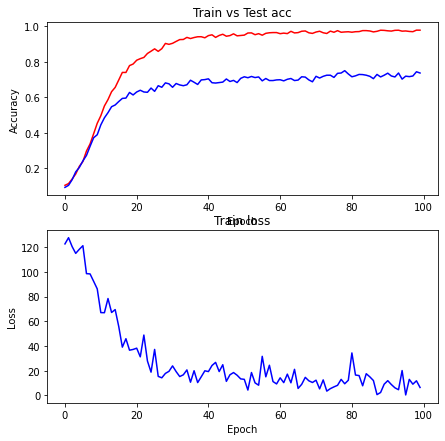

In [33]:
fig, ax = plt.subplots(2, 1, figsize=(7,7))
ax[0].plot(train_acc_for_epoch, color='red')
ax[0].plot(test_acc_for_epoch, color='blue')
ax[0].set_title('Train vs Test acc')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')

ax[1].plot(train_loss_for_epoch, color='blue')
ax[1].set_title('Train loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
